## Neural Networks

In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

# import plotly.plotly as py
# from plotly.graph_objs import *



From http://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module

## Basic Manipulations

Matrix/Tensor multiplication

```
mat.dot(mat2)
```

In [2]:
temp1 = np.linspace(0,1,10*5).reshape(5,10)
temp2 = ( (np.linspace(0,1,10*3) )**2 ).reshape(10,3)
temp1.dot(temp2).shape

(5, 3)

Network using numpy, $Y_p$ is the predicted output, $R()$ is the activation function, $W_1$ is the first weight matrix, $W_2$ is the second weight matrix

$$
Y_p = R( X_i W_1 )  W_2.
$$

In the spirit of auto-grad, we need to use the chain rule.



The next step is to calculate the grad and propagate back. Autograd is basically the chain rule. We are insterested in updating the two weight matrices, thus we need $dL/dW_1$ and $dL/dW_2$ element-wise.

$$
dL/dW_1 = \frac{d (Y_p - Y)^2}{ dW_1 } = 2 (Y_p - Y ) \frac{dY_p}{dW_1} = 2 (Y_p - Y ) W_2\frac{dR(X_i W_1)}{d X_i W_1 } \frac{ d X_i W_1 }{ dW_1 } = 2 (Y_p - Y )W_2 \frac{dR(X_i W_1)}{d X_i W_1 } X_i
$$

As $dL/dW_2$ is much easier to calculate.

$$
dL/d W_2 = 2 (Y_p - Y) \frac{dY_p}{ dW_2 } =2 (Y_p - Y) R(X_i W_1)
$$

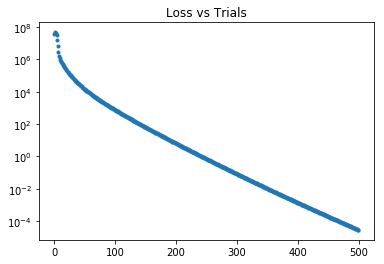

In [55]:
# -*- coding: utf-8 -*-
# import numpy as np

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)
# x = np.linspace(0,1,N*D_in).reshape( N, D_in )
# y = x**2

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

trial_data = []
learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0) # linear activation
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
#         print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    
    trial_data.append( [t, loss] )

trial_data_plt = np.transpose(trial_data)
plt.semilogy( trial_data_plt[0], trial_data_plt[1], '.' )
plt.title('Loss vs Trials')
plt.show()


The same program would be translated into PyTorch version directedly.

1. PyTorch comes with `clamp` function that calcualtes RELU.
2. PyTorch comes with tensor operators that are of high performance.

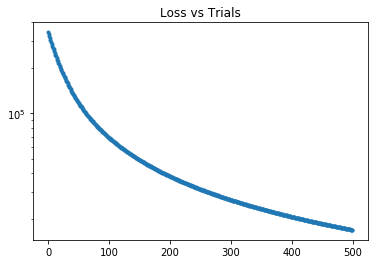

In [50]:
dtype=torch.FloatTensor

torch_x = torch.randn(N, D_in).type(dtype)
torch_y = torch.randn(N,D_out).type(dtype)

torch_w1 = torch.randn(D_in, H).type(dtype)
torch_w2 = torch.randn(H, D_out).type(dtype)

torch_trial_data = []

for t in range(500):
    torch_h = torch_x.mm(torch_w1) #matrix multiply
    torch_h_relu = torch_h.clamp(min=0) # this is basically RELU
    torch_y_pred = torch_h_relu.mm(torch_w2)
    
    torch_loss = (torch_y_pred - torch_y).pow(2).sum()
#     print(t, torch_loss)
    
    torch_grad_y_pred = 2.0*(torch_y_pred - torch_y)
    torch_grad_w2 = torch_h_relu.t().mm(torch_grad_y_pred)
    torch_grad_h_relu = torch_grad_y_pred.mm(torch_w2.t())
    torch_grad_h = torch_grad_h_relu.clone()
    torch_grad_h[torch_h < 0] = 0
    torch_grad_w1 = torch_x.t().mm(torch_grad_h)
    
    torch_w1 -= learning_rate * torch_grad_w1
    torch_w2 -= learning_rate * torch_grad_w2
    
    torch_trial_data.append( [t, torch_loss] )

# print(t, torch_loss)

torch_trial_data_plt = np.transpose(torch_trial_data)
plt.semilogy( torch_trial_data_plt[0], torch_trial_data_plt[1], '.' )
plt.title('Loss vs Trials')
plt.show()

On the other hand, PyTorch also provides autograd which works out the chain rule by itself if data is defined through variables.

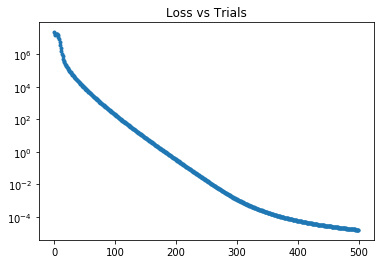

In [56]:
ta_x = Variable( torch.randn(N, D_in).type(dtype), requires_grad=False )
ta_y = Variable( torch.randn(N, D_out).type(dtype), requires_grad=False )

ta_w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad = True)
ta_w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad = True)


ta_trial_data = []
learning_rate = 1e-6
for t in range(500):
    ta_y_pred = ta_x.mm( ta_w1 ).clamp( min=0 ).mm(ta_w2)
    
    ta_loss = (ta_y_pred - ta_y).pow(2).sum()
#     print(t, ta_loss.data[0])
    
    ta_loss.backward()
    
    ta_w1.data -= learning_rate* ta_w1.grad.data
    ta_w2.data -= learning_rate* ta_w2.grad.data
    
    ta_w1.grad.data.zero_()
    ta_w2.grad.data.zero_()
    
    ta_trial_data.append( [t, ta_loss.data[0]] )

# print(t, ta_loss.data[0])


ta_trial_data_plt = np.transpose(ta_trial_data)
plt.semilogy( ta_trial_data_plt[0], ta_trial_data_plt[1], '.' )
plt.title('Loss vs Trials')
plt.show()

In [57]:
print(ta_trial_data[-1])

[499, 1.5851306670811027e-05]


This is a test of the framework. RELU is not the best practice for this task.